
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# ブロックを使用したネットワーク (VGG)

 :ラベル: `sec_vgg`

 AlexNet は、ディープ CNN が良好な結果を達成できるという経験的証拠を提供しましたが、後続の研究者が新しいネットワークを設計する際のガイドとなる一般的なテンプレートは提供していませんでした。次のセクションでは、ディープ ネットワークの設計に一般的に使用されるいくつかのヒューリスティック概念を紹介します。

この分野の進歩は、技術者がトランジスタの配置から論理素子、さらには論理ブロックへの移行を行ったチップ設計における VLSI (超大規模集積回路) の進歩を反映しています (引用: `Mead.1980` )。同様に、ニューラル ネットワーク アーキテクチャの設計も徐々に抽象化され、研究者は個々のニューロンの観点から考えることから層全体、そして今では層のパターンを繰り返すブロックに移行しています。 10 年後、研究者はトレーニング済みモデル全体を使用して、関連するタスクではあるが別のタスクに再利用できるようになりました。このような大規模な事前トレーニング済みモデルは、通常、*基礎モデル*と呼ばれます:cite: `bommasani2021opportunities` 。

ネットワーク設計に戻ります。ブロックを使用するというアイデアは、オックスフォード大学の Visual Geometry Group (VGG) の同名の*VGG*ネットワークから初めて生まれました (引用: `Simonyan.Zisserman.2014` )。ループとサブルーチンを使用することで、最新の深層学習フレームワークを使用してコードにこれらの繰り返し構造を実装するのは簡単です。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


## ( **VGG ブロック**)

 :label: `subsec_vgg-blocks`

 CNN の基本的な構成要素は、次のシーケンスです: (i) 解像度を維持するためのパディングを備えた畳み込み層、(ii) ReLU などの非線形性、(iii) 解像度を低減するための max-pooling などのプーリング層。解決。このアプローチの問題の 1 つは、空間解像度が非常に急速に低下することです。特に、これにより、すべての次元 ($d$) が使い果たされる前に、ネットワークに $\log_2 d$ 畳み込み層のハード制限が課されます。たとえば、ImageNet の場合、この方法で 8 つを超える畳み込み層を使用することは不可能です。

 :citet: `Simonyan.Zisserman.2014`の重要なアイデアは、ブロックの形式での最大プーリングによるダウンサンプリングの間に*複数の*畳み込みを使用することでした。彼らは主に、ディープ ネットワークとワイド ネットワークのどちらのパフォーマンスが優れているかに興味を持っていました。たとえば、2 つの $3 \times 3$ 畳み込みを連続して適用すると、1 つの $5 \times 5$ 畳み込みが行うのと同じピクセルに影響します。同時に、後者は 3 つの $3 \times 3$ 畳み込み ($3 \cdot 9 \cdot c^2$) とほぼ同じ数のパラメーター ($25 \cdot c^2$) を使用します。かなり詳細な分析で、彼らは、深くて狭いネットワークが浅いネットワークよりも大幅に優れていることを示しました。これにより、ディープ ラーニングは、一般的なアプリケーション向けに 100 層を超えるさらに深いネットワークを追求するようになりました。 $3 \times 3$ 畳み込みの積み重ねは、後のディープ ネットワークのゴールド スタンダードになりました (この設計上の決定は、最近 :citet: `liu2022convnet`によってのみ再検討されました)。その結果、小規模な畳み込みの高速実装が GPU の定番になりました (cite: `lavin2016fast` )。

 VGG に戻る: VGG ブロックは、パディングが 1 (高さと幅を維持) の $3\times3$ カーネルと、それに続くストライド 2 (高さと幅を半分にする) の $2 \times 2$ の最大プーリング層による*一連の畳み込み*で構成されます。各ブロックの後)。以下のコードでは、 `vgg_block`という関数を定義して 1 つの VGG ブロックを実装します。

以下の関数は、畳み込み層の数`num_convs`と出力チャネルの数`num_channels`に対応する 2 つの引数を受け取ります。


In [2]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)


## [ **VGGネットワ​​ーク**]

 :label: `subsec_vgg-network`

 AlexNet や LeNet と同様、VGG ネットワークは 2 つの部分に分割できます。1 つ目は主に畳み込み層とプーリング層で構成され、2 つ目は AlexNet のものと同一の完全に接続された層で構成されます。主な違いは、:numref: `fig_vgg`に示すように、畳み込み層が次元を変更しない非線形変換でグループ化され、その後に解像度低減ステップが続くことです。 

![](http://d2l.ai/_images/vgg.svg) :幅: `400px` :ラベル: `fig_vgg`

ネットワークの畳み込み部分は、:numref: `fig_vgg` (これも`vgg_block`関数で定義されています) からのいくつかの VGG ブロックを連続して接続します。この畳み込みのグループ化は、特定の演算の選択には大幅な変更が加えられていますが、過去 10 年間ほとんど変わっていないパターンです。変数`conv_arch`タプルのリスト (ブロックごとに 1 つ) で構成され、各タプルには畳み込み層の数と出力チャネルの数という 2 つの値が含まれます。これらはまさに`vgg_block`関数を呼び出すために必要な引数です。そのため、VGG は、単なる特定の表現ではなく、ネットワークの*ファミリー*を定義します。特定のネットワークを構築するには、ブロックを構成するために`arch`を反復するだけです。


In [3]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)


元の VGG ネットワークには 5 つの畳み込みブロックがあり、最初の 2 つはそれぞれ 1 つの畳み込み層を持ち、後の 3 つはそれぞれ 2 つの畳み込み層を含みます。最初のブロックには 64 の出力チャネルがあり、後続のブロックごとに出力チャネルの数が 2 倍になり、その数は 512 に達します。このネットワークは 8 つの畳み込み層と 3 つの全結合層を使用するため、VGG-11 と呼ばれることがよくあります。


In [4]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])


Sequential output shape:	 torch.Size([1, 256, 28, 28])


Sequential output shape:	 torch.Size([1, 512, 14, 14])


Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])


Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])


Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])



ご覧のとおり、各ブロックで高さと幅を半分にし、ネットワークの完全に接続された部分による処理のために表現を平坦化する前に、最終的に高さと幅が 7 に達します。 :citet: `Simonyan.Zisserman.2014` VGG の他のいくつかの亜種について説明しました。実際、新しいアーキテクチャを導入する際には、速度と精度のトレードオフが異なるネットワーク*ファミリ*を提案することが一般的になっています。

## トレーニング

[ **VGG-11 は AlexNet よりも計算量が多いため、チャネル数が少ないネットワークを構築します。** ] Fashion-MNIST のトレーニングにはこれで十分です。 [**モデルトレーニング**] プロセスは、:numref: `sec_alexnet`の AlexNet のプロセスと似ています。再度、検証とトレーニング損失がほぼ一致していることを観察し、少量の過学習のみを示唆しています。


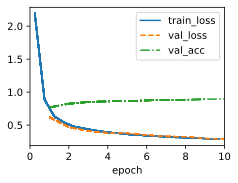

In [5]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)


## まとめ

VGG は最初の真に現代的な畳み込みニューラル ネットワークであると主張する人もいるかもしれません。 AlexNet は深層学習を大規模に効果的にするコンポーネントの多くを導入しましたが、複数の畳み込みのブロックや深くて狭いネットワークの優先などの重要なプロパティを導入したのはおそらく VGG です。また、これは実際に同様にパラメータ化されたモデルのファミリー全体である最初のネットワークでもあり、実務者は複雑さと速度の間で十分なトレードオフを実現できます。これは、最新の深層学習フレームワークが輝く場所でもあります。ネットワークを指定するために XML 構成ファイルを生成する必要はなくなり、単純な Python コードを使用してネットワークを組み立てることができます。

ごく最近、ParNet :cite: `Goyal.Bochkovskiy.Deng.ea.2021` 、多数の並列計算を通じて、より浅いアーキテクチャを使用して競争力のあるパフォーマンスを達成できることを実証しました。これはエキサイティングな開発であり、将来の建築設計に影響を与えることが期待されています。ただし、この章の残りの部分では、過去 10 年間の科学の進歩の道をたどります。

## 演習
1. AlexNet と比較すると、VGG は計算の点ではるかに遅く、より多くの GPU メモリも必要とします。<ol><li> AlexNet と VGG に必要なパラメータの数を比較します。
1. 畳み込み層と全結合層で使用される浮動小数点演算の数を比較します。
1. 完全に接続された層によって生じる計算コストを削減するにはどうすればよいでしょうか?



[ディスカッション](https://discuss.d2l.ai/t/78)
